# Paths

In [1]:
data_path = "./data"
model_checkpoint_path = "./output/model/model_checkpoint.hdf5"
model_summary_path = "./output/model/model_summary.svg"
config_path = "./config"

# Configurations

In [2]:
img_dim = 256
nb_neighbors = 5
batch_size = 32
kernel = 3
channel = 3
epochs = 10
patience = 50
num_classes = 313
kernel = 3
weight_decay = 1e-3
epsilon = 1e-8
lr = 1e-5
# temperature parameter T
T = 0.38

# Imports

In [3]:
import os
import numpy as np
import glob
from random import randint, shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
import cv2 as cv
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
from keras.utils import plot_model
import sklearn.neighbors as nn
from keras.callbacks import ModelCheckpoint
import keras
import random


Using TensorFlow backend.


# utils


## show img by path/img

In [4]:
def show_img_path(path):
    img=mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [5]:
def show_img(img):
    imgplot = plt.imshow(img)
    plt.show()

## RGB to LAB

In [6]:
def rgb_to_lab(img):
    return  cv.cvtColor(img, cv.COLOR_BGR2LAB)
#     return color.rgb2lab(img)

## soft encoding

In [7]:
def get_soft_encoding(image_ab, nn_finder, nb_q):
    h, w = image_ab.shape[:2]
    a = np.ravel(image_ab[:, :, 0])
    b = np.ravel(image_ab[:, :, 1])
    ab = np.vstack((a, b)).T
    # Get the distance to and the idx of the nearest neighbors
    dist_neighb, idx_neigh = nn_finder.kneighbors(ab)
    # Smooth the weights with a gaussian kernel
    sigma_neighbor = 5
    wts = np.exp(-dist_neighb ** 2 / (2 * sigma_neighbor ** 2))
    wts = wts / np.sum(wts, axis=1)[:, np.newaxis]
    # format the tar get
    y = np.zeros((ab.shape[0], nb_q))
    idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
    y[idx_pts, idx_neigh] = wts
    y = y.reshape(h, w, nb_q)
    return y

# Loading data

In [8]:
list_imgs = glob.glob(data_path + "/*")
data_size = len(list_imgs)
print("Data size = " + str(data_size))
# suffle dataset
shuffle(list_imgs)


Data size = 2686


## Preview sample data

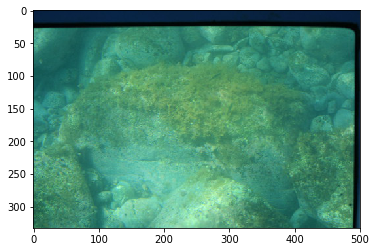

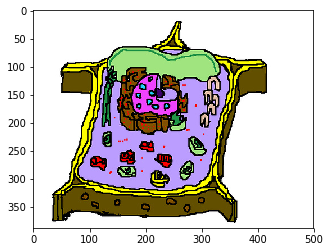

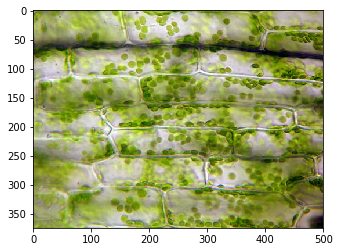

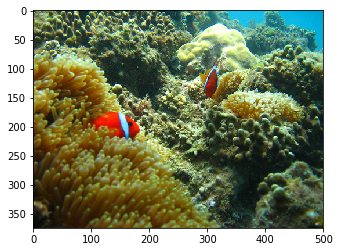

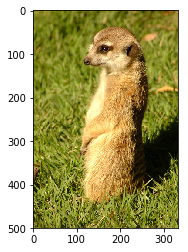

In [9]:
num_to_sample = 5
for i in range(num_to_sample):
    try:
        index = randint(0, data_size-1)
        img = list_imgs[index]
        show_img_path(img)
    except:
        pass
        

## Find color distribution in dataset

## find size distribution in dataset

# Split data


In [10]:
split_val = 0.3
split_num = int(data_size*split_val)
x_img_val = list_imgs[0:split_num]
x_img_train = list_imgs[split_num:]

train_len = len(x_img_train)
test_len = len(x_img_val)

print("Training on {} example and validating on {} example"
      .format(train_len, test_len))

Training on 1881 example and validating on 805 example


# Generate batch

In [21]:
q_ab = np.load(config_path + "/pts_in_hull.npy")
nb_q = q_ab.shape[0]
# Fit a NN to q_ab
nn_finder = nn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)
def get_batch(full_list, batch_size=batch_size):
    i_batch = 0
    x = np.empty((batch_size, img_dim, img_dim, 1), dtype=np.float32)
    y = np.empty((batch_size, img_dim//4, img_dim//4, nb_q), dtype=np.float32)
    while i_batch < batch_size:
        try:
            img_index =  random.randint(0,data_size)
            img = list_imgs[img_index]
            rgb = cv.imread(img)
            lab_img = rgb_to_lab(rgb)
            out_lab = cv.resize(lab_img, (img_dim//4, img_dim//4), cv.INTER_CUBIC)
            out_ab = out_lab[:, :, 1:].astype(np.int32) - 128
            ab_enc = get_soft_encoding(out_ab, nn_finder, nb_q)
            l = cv.imread(img, 0)/255.
            l = cv.resize(l, (img_dim, img_dim), cv.INTER_CUBIC)
            x[i_batch, :, :, 0] = l
            y[i_batch] = ab_enc
            i_batch = i_batch + 1 
        except Exception as e:
            print(e)
            pass
    yield x, y




# MODEL

## Build model

In [22]:
def build_model():
    l2_reg = l2(1e-3)
    input_tensor = Input(shape=(img_dim, img_dim, 1))
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(input_tensor)
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg, strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg,
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_3', kernel_initializer="he_normal",
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='pred')(x)

    model = Model(inputs=input_tensor, outputs=outputs, name="ColorNet")
    return model


## Model details


In [23]:
model = build_model()
print(model.summary())
plot_model(model, to_file=model_summary_path, show_layer_names=True, show_shapes=True)



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
batc

## Loss function

In [25]:
# Load the color prior factor that encourages rare colors
prior_factor = np.load( config_path + "/prior_factor.npy")
prior_factor = prior_factor.astype(np.float32)
def categorical_crossentropy_color(y_true, y_pred):
    q = 313
    y_true = K.reshape(y_true, (-1, q))
    y_pred = K.reshape(y_pred, (-1, q))

    idx_max = K.argmax(y_true, axis=1)
    weights = K.gather(prior_factor, idx_max)
    weights = K.reshape(weights, (-1, 1))

    # multiply y_true by weights
    y_true = y_true * weights

    cross_ent = K.categorical_crossentropy(y_pred, y_true)
    cross_ent = K.mean(cross_ent, axis=-1)

    return cross_ent

## Train model

In [ ]:
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss',
                                   verbose=1, save_best_only=True)
callbacks = [model_checkpoint]
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.99, epsilon=epsilon)
model.compile(optimizer=adam, loss=categorical_crossentropy_color)
history  = model.fit_generator(get_batch(x_img_train),
                            steps_per_epoch=len(x_img_train) // batch_size,
                            validation_data=(get_batch(x_img_val)),
                            validation_steps=len(x_img_val) // batch_size,
                            epochs=epochs,
                            verbose=1,
                            callbacks=callbacks,
                            use_multiprocessing=True,
                            workers=8
                            )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10


/home/aya/Programs/anaconda3/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.